# Transfer learning
* Download data
* Get a pretrained model
* Do training
* Load results from tensorboard writer

In [1]:
import torch
import torchvision
from torch import nn
from torchvision import transforms

print(f"torch {torch.__version__} | torchvision {torchvision.__version__}")

torch 2.0.1+cu118 | torchvision 0.15.2+cu118


In [2]:
# import torchinfo
try:
    from torchinfo import summary
except:
    print(f"[INFO] installing torchinfo...")
    !pip install torchinfo
    from torchinfo import summary

In [3]:
# import modules from sources
from sources import utils, datasetup, engine, models

2023-11-07 14:51:47.228029: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-07 14:51:47.270338: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-07 14:51:47.916690: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
# device agnostic
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
# download data
source = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip"
image_path = datasetup.download_data(source=source)
image_path

[INFO] creating data/images...
[INFO] downloading pizza_steak_sushi.zip to data...
[INFO] extracting pizza_steak_sushi.zip to data/images...
[INFO] removing pizza_steak_sushi.zip...


PosixPath('data/images')

In [6]:
# setup train and test directories
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir, test_dir

(PosixPath('data/images/train'), PosixPath('data/images/test'))

In [7]:
# setup an efficient net pretrained model
model, model_transforms = models.create_effnet(
    effnet_version=0
)
model_transforms

[INFO] creating EfficientNet_B0...


ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [8]:
# create dataloaders
train_dataloader, test_dataloader, class_names = datasetup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    train_transforms=model_transforms,
    test_transforms=model_transforms,
    batch_size=32
)

[INFO] creating dataloaders... 
train_dataloader: <torch.utils.data.dataloader.DataLoader object at 0x7fe498126210> 
test_dataloader: <torch.utils.data.dataloader.DataLoader object at 0x7fe49edda790> 
number of class_names: 3


In [9]:
# setup loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)

In [10]:
# train pretrained model with new data
results = engine.train_tsb_writer(
    model=model,
    train_dataloader = train_dataloader,
    test_dataloader = test_dataloader,
    loss_fn = loss_fn,
    optimizer = optimizer,
    epochs=20,
    device=device,
    writer=utils.create_writer()
)

[INFO] creating writer log at: writerLog


  0%|          | 0/20 [00:00<?, ?it/s]

epoch: 0 | train_loss: 1.0315 | train_acc: 0.5273 | test_loss: 0.8709 | test_acc: 0.7225
epoch: 1 | train_loss: 0.8371 | train_acc: 0.7031 | test_loss: 0.8138 | test_acc: 0.6809
epoch: 2 | train_loss: 0.7327 | train_acc: 0.7578 | test_loss: 0.7267 | test_acc: 0.7538
epoch: 3 | train_loss: 0.6390 | train_acc: 0.8516 | test_loss: 0.6711 | test_acc: 0.8153
epoch: 4 | train_loss: 0.6594 | train_acc: 0.7461 | test_loss: 0.6081 | test_acc: 0.8258
epoch: 5 | train_loss: 0.5603 | train_acc: 0.8242 | test_loss: 0.5784 | test_acc: 0.8248
epoch: 6 | train_loss: 0.4888 | train_acc: 0.8086 | test_loss: 0.5285 | test_acc: 0.8456
epoch: 7 | train_loss: 0.4678 | train_acc: 0.9531 | test_loss: 0.5303 | test_acc: 0.8352
epoch: 8 | train_loss: 0.4295 | train_acc: 0.9453 | test_loss: 0.5357 | test_acc: 0.8352
epoch: 9 | train_loss: 0.5404 | train_acc: 0.7969 | test_loss: 0.5277 | test_acc: 0.8153
epoch: 10 | train_loss: 0.4536 | train_acc: 0.8242 | test_loss: 0.4326 | test_acc: 0.8968
epoch: 11 | train_lo

In [11]:
%load_ext tensorboard
%tensorboard --logdir writerLog/ --port 0

In [12]:
# save model
model_path = utils.save_model(
    model=model,
    model_dir="saved_models/"
)

# load save model

In [13]:
# create model
loaded_effnet_b0, loaded_effnet_b0_transforms = models.create_effnet(effnet_version=0)

[INFO] creating EfficientNet_B0...


In [14]:
# loading stat dict
utils.load_saved_model(
    loaded_model=loaded_effnet_b0,
    loaded_path=model_path
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[-2.2235, -0.9499,  1.9928]], device='cuda:0')


'sushi'

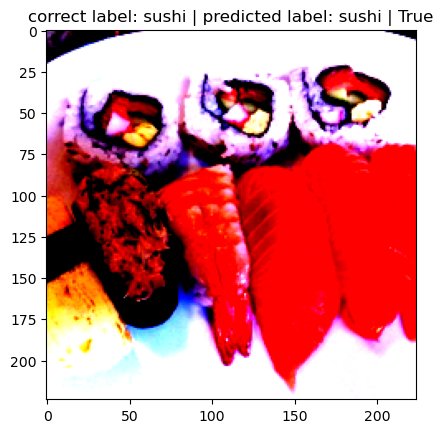

In [15]:
# predict a random image label
import random

random_path = random.choice(list(test_dir.glob("*/*")))

utils.predict_label(
    model = model,
    image_path=random_path,
    class_names=class_names,
    transforms=model_transforms,
    device=device,
    INFO=True
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[-2.2235, -0.9499,  1.9928]], device='cuda:0')


'sushi'

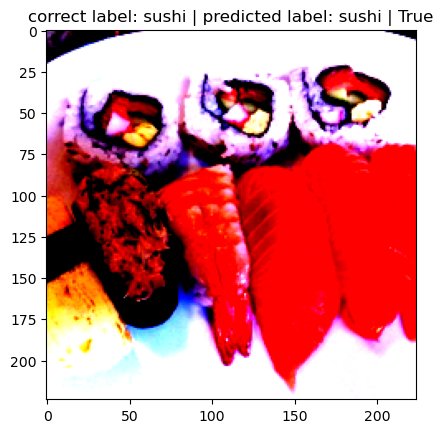

In [16]:
# predict image label from saved model
utils.predict_label(
    model = loaded_effnet_b0,
    image_path=random_path,
    class_names=class_names,
    transforms=model_transforms,
    device=device,
    INFO=True
)